***Welcome to Medical image processing in Python***<br/>

Presented by: Reza Saadatyar (2024-2025) <br/>
E-mail: Reza.Saadatyar@outlook.com<br/>
**[GitHub](https://github.com/RezaSaadatyar/Deep-Learning-in-python)**

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597)

**Outline:**<br/>
**▪ Importing the dataset**<br/>
**▪ Convert the images into array & masks to binary**<br/>
**▪ [Prepare TensorFlow datasets for training, validation, and testing](https://github.com/RezaSaadatyar/Deep-Learning-in-python/blob/main/Code/02_tensorflow_data_loading_and_processing.ipynb)**<br/>
**▪ U-Net Architectur**<br/>
**▪ Segmentation Metrics**<br/>
**▪ Callbacks**<br/>
**▪ Training the model**<br/>
**▪ Test the model**<br/>
**▪ Load previously trained Model**

In [ ]:
!git clone https://github.com/RezaSaadatyar/Medical-Image-Processing
!ls /content/Medical-Image-Processing
%cd /content/Medical-Image-Processing/Code
import sys
sys.path.append('/content/Medical-Image-Processing/Code/Functions')

pip install colorama

<font color='#FF000e' size="4.8" face="Arial"><b>Importing libraries</b></font>

In [15]:
import pprint
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Union

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Activation, BatchNormalization

from Functions.image_processor import ImageProcessor
from Functions.filepath_extractor import FilePathExtractor

<font color=#eff30b size="4.5" face="Arial"><b>1️⃣ Importing the dataset</b></font>

In [17]:
# ================================================ Images ======================================================
img_format_type = "png"   # png, jpg, jpeg, tiff, bmp, tif, etc.
# image_path = "D:/Medical-Image-Processing/Data/Membrance/images/"
image_path = "/content/Medical-Image-Processing/Data/Membrance/images"

# Create an instance of DirectoryReader with the directory path and file format
obj_inputs = FilePathExtractor(directory_path=image_path, format_type=img_format_type)
img_filesname = obj_inputs.filesname         # List of filesname in the directory

pprint.pprint({"Image files": img_filesname}, compact=True, width=120)

{'Image files': ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png',
                 '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png',
                 '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png']}


In [18]:
# ==================================================== Masks ===================================================
mask_format_type = "png"  # png, jpg, jpeg, tiff, bmp, tif, etc.

# mask_path = "D:/Medical-Image-Processing/Data/Membrance/masks/"
mask_path = "/content/Medical-Image-Processing/Data/Membrance/masks"

# Create an instance of DirectoryReader with the directory path and file format
obj_masks = FilePathExtractor(directory_path=mask_path, format_type=mask_format_type)
mask_filesname = obj_masks.filesname      # List of filesname in the directory

pprint.pprint({"Mask files": mask_filesname}, compact=True, width=120)

{'Mask files': ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png',
                '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png',
                '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png']}


In [19]:
# ============================================ Check of the Images =============================================
# Compare the base filenames (without extensions) of input files and mask files
# This line checks if the list of base filenames for input files matches the list of base filenames for mask files
[i.split(img_format_type)[0] for i in img_filesname] == [i.split(mask_format_type)[0] for i in mask_filesname]

True

<font color=#09eb14 size="4.5" face="Arial"><b> 2️⃣ Convert the images into array & masks to binary</b></font>

In [44]:
# ================================================ Images ======================================================
# Create an instance of the `ImageProcessor` class
obj = ImageProcessor()

# Use the `read_images` method of the `ImageProcessor` object to load images from the directory
# The images are expected to be in "png or tif" format, and they are converted into a NumPy array
images = obj.read_images(image_path=image_path, format_type=img_format_type, resize=None, normalize=True)

Image shape: (30, 512, 512, 1)


In [45]:
# ==================================================== Masks ===================================================
# Use the `mask_read` method of the `ImageProcessor` object to load mask images from the directory
# The masks are expected to be in "TIF" format, and they are converted into a NumPy array
masks = obj.read_masks(mask_path=mask_path, format_type=mask_format_type, resize=None, normalize=True, num_classes=2)

masks.shape = (30, 512, 512, 1)
Total number of classes in masks: 2
Class counts in masks:
  Class 0.00: 1727250
  Class 1.00: 6137070


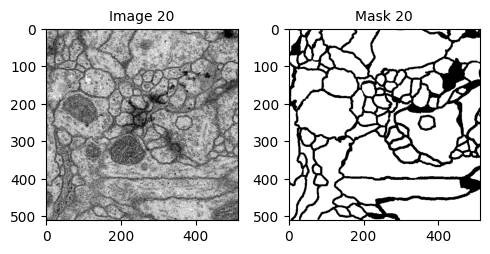

In [46]:
ind = 20 # Set the index of the image and mask to display
plt.figure(figsize=(5, 3))
plt.subplot(121); plt.imshow(images[ind], cmap='gray'); plt.title(f'Image {ind}', fontsize=10)
plt.subplot(122); plt.imshow(masks[ind], cmap='gray'); plt.title(f'Mask {ind}', fontsize=10)
plt.tight_layout() # Adjust the layout to prevent overlap between subplots

<font color=#ee0caa size="4.5" face="Arial"><b>3️⃣ [Prepare TensorFlow datasets for training, validation, and testing](https://github.com/RezaSaadatyar/Deep-Learning-in-python/blob/main/Code/02_tensorflow_data_loading_and_processing.ipynb)</b></font>

In [47]:
def prepare_dataset(
    data: Union[np.ndarray, tf.Tensor],
    labels: Union[np.ndarray, tf.Tensor],
    train_size: float = 0.7,
    valid_size: float = 0.15,
    batch_size: int = 8,
    shuffle_train: bool = True,
    shuffle_buffer_size: int = 1000
) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """
    This function handles the complete pipeline from raw data to optimized TensorFlow Dataset objects,
    including data splitting, shuffling, batching, and prefetching for optimal performance.

    Args:
        data: Input features as either numpy array or TensorFlow tensor
               Shape should be (num_samples, ...features_dims)
        labels: Corresponding labels as either numpy array or TensorFlow tensor
                Shape should be (num_samples, ...label_dims)
        train_size: Proportion of data for training
        valid_size: Proportion of data for validation
        batch_size: Number of samples per batch (positive integer)
        shuffle_train: Whether to shuffle training data
        shuffle_buffer_size: Size of buffer used for shuffling (larger = better shuffling but more memory)

    Returns:
        Tuple of (train_dataset, valid_dataset, test_dataset)
    """

    # Validate split proportions
    if train_size + valid_size > 1.0: raise ValueError("train_size + valid_size must not exceed 1.0")
    if train_size < valid_size: raise ValueError("Training set should typically be larger than validation set")

    # Convert TensorFlow tensors to numpy arrays
    if tf.is_tensor(data): data = data.numpy()
    if tf.is_tensor(labels): labels = labels.numpy()

    # Verify data and labels compatibility
    if len(data) != len(labels):
        raise ValueError(f"Mismatched lengths: data has {len(data)} samples but labels has {len(labels)}")

    # Normalize images to [0, 1]
    if data.max() > 1.0:  # Assuming data is in [0, 255]
        data = data / 255.0

    # ======================================== DATA SPLITTING ==================================================
    # First split separates test set from training+validation
    x_train_val, x_test, y_train_val, y_test = train_test_split(
        data,
        labels,
        train_size=train_size + valid_size,  # Combined size for train+val
        test_size=1.0 - (train_size + valid_size),  # Remainder for test
        random_state=24,  # Fixed seed for reproducibility
        # stratify=labels if len(set(labels)) > 1 else None  # Optional stratification
    )

    # Second split divides train+val into separate sets
    # Calculate relative proportion of validation within train+val subset
    valid_proportion = valid_size / (train_size + valid_size)
    x_train, x_valid, y_train, y_valid = train_test_split(
        x_train_val,
        y_train_val,
        train_size=1.0 - valid_proportion,  # Relative train size
        test_size=valid_proportion,          # Relative validation size
        random_state=24,  # Same seed for consistency
        # stratify=y_train_val if len(set(y_train_val)) > 1 else None
    )

    # ======================================= DATASET CREATION =================================================
    # Create TensorFlow Dataset objects with proper type casting
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(x_train, tf.float32),  # Convert features to float32
        tf.cast(y_train, tf.float32)    # Convert labels to float32
    ))

    valid_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(x_valid, tf.float32), tf.cast(y_valid, tf.float32))
    )
    test_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(x_test, tf.float32), tf.cast(y_test, tf.float32))
    )

    # ====================================== DATASET OPTIMIZATION ==============================================
    # Shuffle training data if enabled (recommended for better training)
    if shuffle_train:
        train_dataset = train_dataset.shuffle(
            buffer_size=min(shuffle_buffer_size, len(x_train)),  # Don't exceed dataset size
            reshuffle_each_iteration=True  # Important for proper epoch training
        )

    # Batch all datasets for efficient processing
    train_dataset = train_dataset.batch(batch_size)
    valid_dataset = valid_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)

    # Prefetch data to overlap preprocessing and model execution
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)  # Let TensorFlow optimize buffer size
    valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

    # Print dataset info
    print(f"Training set:   {x_train.shape} features, {y_train.shape} labels")
    print(f"Validation set: {x_valid.shape} features, {y_valid.shape} labels")
    print(f"Test set:       {x_test.shape} features, {y_test.shape} labels")
    print(f"\nBatch size:     {batch_size}")
    print(f"Training shuffle: {'enabled' if shuffle_train else 'disabled'}")
    print("\t")
    pprint.pprint(train_dataset.element_spec, width=80)

    return train_dataset, valid_dataset, test_dataset

In [48]:
batch_size = 4

# Assuming data_resize and masks_resize are your input data and masks
train_dataset, valid_dataset, test_dataset = prepare_dataset(
    data=images,
    labels=masks,
    train_size=0.6,
    valid_size=0.25,
    batch_size=batch_size,
    shuffle_train=True,
    shuffle_buffer_size=1000,
)

Training set:   (17, 512, 512, 1) features, (17, 512, 512, 1) labels
Validation set: (8, 512, 512, 1) features, (8, 512, 512, 1) labels
Test set:       (5, 512, 512, 1) features, (5, 512, 512, 1) labels

Batch size:     4
Training shuffle: enabled
	
(TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))


In [ ]:
# Convert the validation dataset to a list of numpy arrays
list(valid_dataset.as_numpy_iterator())
# or
# Iterate over the first 1 elements of the dataset and print each pair of (x, y) values
for ind_x, ind_y in valid_dataset.take(1):
    # Print the input and output tensors in a formatted string
    print(f"Image:\n{ind_x}")

<font color=#ff12f3 size="4.5" face="Arial"><b>4️⃣ U-Net Architectur</b></font>

![unet-3.png](attachment:unet-3.png) ![unet block.png](<attachment:unet block.png>)

In [50]:
def unet_model(
    img_height: int,
    img_width: int,
    img_channels: int,
    base_filters: int = 16,  # Added base_filters parameter
    kernel_size: tuple = (3, 3),
    transpose_kernel_size: tuple = (2, 2),
    act_dropout: bool = False,
    use_batchnorm: bool = False,
    dropout_rates: dict = {'shallow':0.1, 'mid':0.2, 'deep':0.3},
    n_class: int = 1):
    """
    Args:
        img_height: Height of input images
        img_width: Width of input images
        img_channels: Number of input channels
        base_filters: Base number of filters for the first layer (default: 16)
        kernel_size: Size of the convolution kernels (default: (3, 3))
        transpose_kernel_size: Size of the transpose convolution kernels (default: (2, 2))
        act_dropout: Global toggle for dropout (default: False)
        use_batchnorm: Whether to use BatchNormalization (default: False)
        dropout_rates: Dictionary defining dropout rates for different depths
        n_class: Number of output classes (default: 1 for binary segmentation)

    Returns:
        A compiled Keras Model instance

    Example:
        img_height, img_width, img_channels = list(train_dataset.element_spec[0].shape)
        model = unet_model(img_height, img_width, img_channels)
    """

    # Input layer and normalization
    inputs = Input((img_height, img_width, img_channels))

    # Lambda layer to check max value and normalize only if > 1
    def normalize_inputs(x):
        max_val = tf.reduce_max(x)
        return tf.cond(tf.greater(max_val, 1.0), lambda: x / 255.0, lambda: x)

    inputs = Lambda(normalize_inputs, output_shape=(img_height, img_width, img_channels))(inputs)

    # ======================================= ENCODER (Contracting Path) =======================================
    # Block 1 (Shallow: Lowest Dropout)
    c1 = Conv2D(base_filters, kernel_size, kernel_initializer='he_normal', padding='same')(inputs)
    if use_batchnorm: c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(base_filters, kernel_size, kernel_initializer='he_normal', padding='same')(c1)
    if use_batchnorm: c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2 (Shallow: Low Dropout)
    c2 = Conv2D(base_filters * 2, kernel_size, kernel_initializer='he_normal', padding='same')(p1)
    if use_batchnorm: c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(base_filters * 2, kernel_size, kernel_initializer='he_normal', padding='same')(c2)
    if use_batchnorm: c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    if act_dropout: c2 = Dropout(dropout_rates['shallow'])(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3 (Mid-Depth: Moderate Dropout)
    c3 = Conv2D(base_filters * 4, kernel_size, kernel_initializer='he_normal', padding='same')(p2)
    if use_batchnorm: c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(base_filters * 4, kernel_size, kernel_initializer='he_normal', padding='same')(c3)
    if use_batchnorm: c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    if act_dropout: c3 = Dropout(dropout_rates['mid'])(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4 (Mid-Depth: Moderate Dropout)
    c4 = Conv2D(base_filters * 8, kernel_size, kernel_initializer='he_normal', padding='same')(p3)
    if use_batchnorm: c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(base_filters * 8, kernel_size, kernel_initializer='he_normal', padding='same')(c4)
    if use_batchnorm: c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    if act_dropout: c4 = Dropout(dropout_rates['mid'])(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # ======================================= BOTTLENECK (Deepest Layer) =======================================
    c5 = Conv2D(base_filters * 16, kernel_size, kernel_initializer='he_normal', padding='same')(p4)
    if use_batchnorm: c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Conv2D(base_filters * 16, kernel_size, kernel_initializer='he_normal', padding='same')(c5)
    if use_batchnorm: c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    if act_dropout: c5 = Dropout(dropout_rates['deep'])(c5)  # Maximum dropout

    # ======================================== DECODER (Expansive Path) ========================================
    # Upsample and concatenate with corresponding encoder features
    up1 = Conv2DTranspose(base_filters * 8, transpose_kernel_size, strides=(2, 2), padding='same')(c5)
    concat1 = concatenate([c4, up1], axis=3)
    c6 = Conv2D(base_filters * 8, kernel_size, kernel_initializer='he_normal', padding='same')(concat1)
    if use_batchnorm: c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Conv2D(base_filters * 8, kernel_size, kernel_initializer='he_normal', padding='same')(c6)
    if use_batchnorm: c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    if act_dropout: c6 = Dropout(dropout_rates['mid'])(c6)  # Matches Block 4

    up2 = Conv2DTranspose(base_filters * 4, transpose_kernel_size, strides=(2, 2), padding='same')(c6)
    concat2 = concatenate([c3, up2], axis=3)
    c7 = Conv2D(base_filters * 4, kernel_size, kernel_initializer='he_normal', padding='same')(concat2)
    if use_batchnorm: c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(base_filters * 4, kernel_size, kernel_initializer='he_normal', padding='same')(c7)
    if use_batchnorm: c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    if act_dropout: c7 = Dropout(dropout_rates['mid'])(c7)  # Matches Block 3

    up3 = Conv2DTranspose(base_filters * 2, transpose_kernel_size, strides=(2, 2), padding='same')(c7)
    concat3 = concatenate([c2, up3], axis=3)
    c8 = Conv2D(base_filters * 2, kernel_size, kernel_initializer='he_normal', padding='same')(concat3)
    if use_batchnorm: c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Conv2D(base_filters * 2, kernel_size, kernel_initializer='he_normal', padding='same')(c8)
    if use_batchnorm: c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    if act_dropout: c8 = Dropout(dropout_rates['shallow'])(c8)  # Matches Block 2

    up4 = Conv2DTranspose(base_filters, transpose_kernel_size, strides=(2, 2), padding='same')(c8)
    concat4 = concatenate([c1, up4], axis=3)
    c9 = Conv2D(base_filters, kernel_size, kernel_initializer='he_normal', padding='same')(concat4)
    if use_batchnorm: c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Conv2D(base_filters, kernel_size, kernel_initializer='he_normal', padding='same')(c9)
    if use_batchnorm: c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    # No dropout in final decoder block (shallowest layer)

    # Output layer
    if n_class < 1: raise ValueError("Number of classes must be at least 1")
    act = 'sigmoid' if n_class == 1 else 'softmax'
    c10 = Conv2D(n_class, (1, 1), activation=act)(c9)  # 1x1 conv for output

    model = Model(inputs=inputs, outputs=c10)
    return model

In [51]:
# Convert any tf.placeholder usage to tf.compat.v1.placeholder
tf.placeholder = tf.compat.v1.placeholder if hasattr(tf, 'placeholder') else None

img_height, img_width, img_channels = list(train_dataset.element_spec[0].shape[1:])

model = unet_model(img_height,
                   img_width,
                   img_channels,
                   base_filters=16,
                   kernel_size=(3, 3),
                   transpose_kernel_size=(2, 2),
                   act_dropout=False,
                   use_batchnorm=False,
                   dropout_rates={'shallow':0.1, 'mid':0.2, 'deep':0.3}  # Custom rates
                  )
# model.summary()

<font color=#08d8f3 size="4.5" face="Arial"><b>5️⃣ Segmentation Metrics</b></font><br/>
The selection of the appropriate loss function and metrics for the U-Net model depends on the specifics of the segmentation project (such as binary or multi-class), the characteristics of your dataset (like class imbalance), and your objectives (for instance, prioritizing precision or recall).

**Loss Functions:**<br/>
▪ `binary_crossentropy:` Standard loss for binary classification/segmentation (pixel-wise 0 or 1).<br/>
▪ `metrics['dice_coef_loss']:` 1 - Dice coefficient, emphasizes overlap between predicted and true regions.<br/>
▪ `metrics['iou_coef_loss']:` 1 - IoU, focuses on intersection over union.<br/>
▪ `metrics['combined_loss']:` Combined BCE + Dice loss; Lower is better.<br/>
▪ `sparse_categorical_crossentropy:` For multi-class segmentation with integer labels (not one-hot encoded).<br/>

**Metrics:**<br/>
▪ `accuracy:` Proportion of correctly classified pixels (can be misleading for imbalanced data).<br/>
▪ `metrics['dice_coef']:` Measures overlap (2 * intersection / union), ranges from 0 to 1.<br/>
▪ `metrics['iou']:` Intersection over union, ranges from 0 to 1.<br/>
▪ `Recall(): `True positives / (true positives + false negatives), good for detecting all positives.<br/>
▪ `Precision():` True positives / (true positives + false positives), good for reducing false positives.<br/>

🔹 `Dice loss` optimizes the overlap between predicted and true masks, making it crucial for segmentation tasks. It's especially effective for imbalanced datasets, like detecting small tumors in medical imaging, where binary cross-entropy may focus too much on the dominant background class.<br/>
🔹 `Binary cross-entropy` is a simpler and effective choice for pixel-wise classification when the dataset is well-balanced and predictions are confident. However, it is less robust to class imbalances compared to Dice or IoU losses.<br/>
🔹 Use `iou_coef_loss `when the task emphasizes precise region overlap instead of boundary smoothness, such as in object detection-like segmentation. IoU loss serves as an effective alternative to Dice, as it penalizes false positives and negatives differently.<br/>
🔹 The combination of `binary_crossentropy`, which provides pixel-level guidance, and `dice_coef_loss`, which focuses on overall overlap, helps balance local detail with structural fidelity. An initial alpha value of 0.5 is recommended, with adjustments made according to validation results.<br/>

In [52]:
def segmentation_metrics(alpha: float = 0.5):
    """
    Creates and returns a collection of metrics and loss functions specifically designed for image segmentation tasks.
    Includes implementations of:
    - Dice coefficient (F1 score for segmentation)
    - Dice loss (1 - Dice coefficient)
    - Intersection over Union (IoU/Jaccard index)
    - IoU loss (1 - IoU)
    - Combined loss (binary crossentropy + Dice loss)

    All functions are decorated with @tf.function for optimized TensorFlow graph execution and include numerical
    stability smoothing (epsilon value).

    Args:
    - alpha (float): Weighting factor between BCE and Dice loss in the combined loss.

    Returns:
    - dict: A dictionary containing metric/loss functions:
      - 'dice_coef': Dice coefficient metric; Higher is better (range 0-1)
      - 'dice_coef_loss': Dice loss function; Lower is better (range 0-1)
      - 'iou': IoU metric; Higher is better (range 0-1)
      - 'iou_coef_loss': IoU loss function; Lower is better (range 0-1)
      - 'combined_loss': Combined BCE + Dice loss; Lower is better

    Example:
    - adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False) # Or 'adam', 'rmsprop'
    - loss=metrics['combined_loss'], # Or binary_crossentropy, 'sparse_categorical_crossentropy', metrics['dice_coef_loss'], 'iou_coef_loss', 'combined_loss',
    - metrics = segmentation_metrics(labels=train_masks, alpha=0.2)
    - model.compile(optimizer=adam, loss=metrics['combined_loss'], metrics=['accuracy',
        metrics['dice_coef'], metrics['iou'], tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
        run_eagerly=False),  # Set run_eagerly=False for better performance
    """
    # Small constant to prevent division by zero and ensure numerical stability
    smooth = 1e-15

    @tf.function
    def dice_coef(y_true, y_pred):
        """
        Computes the Dice coefficient (F1 score) between ground truth and predicted masks.

        The Dice coefficient measures the overlap between two samples, with values ranging
        from 0 (no overlap) to 1 (perfect overlap). Defined as:
        Dice = (2 * |X ∩ Y|) / (|X| + |Y|)

        Args:
        - y_true: Ground truth masks (tensor of shape [batch_size, height, width, channels])
        - y_pred: Predicted probability masks (tensor of same shape as y_true)

        Returns:
            Tensor: Scalar Dice coefficient value
        """
        # Ensure tensors are float32 for consistent computation
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Compute intersection (element-wise multiplication followed by sum)
        intersection = tf.reduce_sum(y_true * y_pred)
        # Compute union (sum of individual masks)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
        # Calculate Dice coefficient with smoothing factor
        return (2. * intersection + smooth) / (union + smooth)

    @tf.function
    def dice_coef_loss(y_true, y_pred):
        """
        Computes Dice loss as 1 - Dice coefficient.

        This loss function is commonly used in segmentation tasks where the target
        is to maximize the Dice coefficient. The loss ranges from 0 (perfect match)
        to 1 (no overlap).

        Args:
        - y_true: Ground truth masks (tensor)
        - y_pred: Predicted masks (tensor)

        Returns:
            Tensor: Scalar Dice loss value
        """
        return 1.0 - dice_coef(y_true, y_pred)

    @tf.function
    def iou(y_true, y_pred):
        """
        Computes Intersection over Union (IoU/Jaccard index) between masks.

        IoU measures the overlap between two samples, with values ranging from
        0 (no overlap) to 1 (perfect overlap). Defined as:
        IoU = |X ∩ Y| / |X ∪ Y|

        Args:
        - y_true: Ground truth masks (tensor)
        - y_pred: Predicted masks (tensor)

        Returns:
            Tensor: Scalar IoU value
        """
        # Ensure tensors are float32 for consistent computation
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Compute intersection
        intersection = tf.reduce_sum(y_true * y_pred)
        # Compute total area covered by both masks
        total = tf.reduce_sum(y_true + y_pred)
        # Compute union (total area minus intersection)
        union = total - intersection
        # Calculate IoU with smoothing factor
        return (intersection + smooth) / (union + smooth)

    @tf.function
    def iou_coef_loss(y_true, y_pred):
        """
        Computes IoU loss as 1 - IoU.

        This loss function is used in segmentation tasks where the target is to
        maximize the IoU metric. The loss ranges from 0 (perfect match) to 1
        (no overlap).

        Args:
        - y_true: Ground truth masks (tensor)
        - y_pred: Predicted masks (tensor)

        Returns:
            Tensor: Scalar IoU loss value
        """
        return 1.0 - iou(y_true, y_pred)

    @tf.function
    def combined_loss(y_true, y_pred):
        """
        Computes a combined loss of binary crossentropy and Dice loss.

        This hybrid loss balances pixel-wise classification (BCE) with region overlap (Dice).
        The weighting factor alpha controls the contribution of each component:
        - Loss = alpha * BCE + (1 - alpha) * Dice_loss

        Args:
        - y_true: Ground truth masks (tensor)
        - y_pred: Predicted masks (tensor)
        - alpha: Weighting factor between BCE and Dice loss (default: 0.5)

        Returns:
            Tensor: Scalar combined loss value
        """
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice = dice_coef_loss(y_true, y_pred)
        return alpha * bce + (1 - alpha) * dice

    # Return all functions in a dictionary for easy access
    return {
        'dice_coef': dice_coef,            # Metric: Higher is better (range 0-1)
        'dice_coef_loss': dice_coef_loss,  # Loss: Lower is better (range 0-1)
        'iou': iou,                        # Metric: Higher is better (range 0-1)
        'iou_coef_loss': iou_coef_loss,    # Loss: Lower is better (range 0-1)
        'combined_loss': combined_loss,     # Loss: Lower is better
    }

In [53]:
metrics = segmentation_metrics(alpha=0.1)

adam = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)

# Compile the model with custom loss and metrics
model.compile(
    optimizer=adam,               # Or 'adam', 'rmsprop'
    loss='binary_crossentropy', # Or binary_crossentropy, 'sparse_categorical_crossentropy', metrics['dice_coef_loss'], 'iou_coef_loss', 'combined_loss'
    metrics=[
        'accuracy',
        metrics['dice_coef'],
        metrics['iou'],
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        ],
    run_eagerly=False,  # Set run_eagerly=False for better performance
    )

<font color=#ffbb54 size="4.5" face="Arial"><b>6️⃣ Callbacks</b></font><br/>
`EarlyStopping`<br/>
▪ Stops training if `val_loss` doesn’t improve for 5 epochs.<br/>
▪ Keeps final weights (not best) when stopping.<br/>
▪ Prevents overfitting, saves time.<br/>

`CSVLogger(csv_path)`<br/>
▪ Logs all metrics (e.g., loss, accuracy) to a CSV file each epoch.<br/>
▪ Creates a persistent record for analysis.<br/>
▪ Track progress, analyze later.<br/>

`ModelCheckpoint`<br/>
▪ Saves the model to a file when `val_loss` improves.<br/>
▪ Only saves the best model (overwrites previous saves).<br/>
▪ Preserves the best model state.<br/>

`ReduceLROnPlateau`<br/>
▪ Reduces learning rate by 10x (e.g., 1e-4 to 1e-5) if `val_loss` stalls for 5 epochs.<br/>
▪ Won’t go below 1e-7; prints updates.<br/>
▪ Helps fine-tune when training plateaus.<br/>

In [54]:
class ShowImageTrainingProgress(keras.callbacks.Callback):
    """
    Custom callback to display input image, ground truth mask, and predicted mask for a specific sample at the
    beginning of the first epoch and end of the last epoch.

    Example:
    - callbacks = [ShowImageTrainingProgress(train_dataset, sample_idx=0)]
    """

    def __init__(self, dataset, sample_idx=0):
        """
        Args:
            dataset: tf.data.Dataset object containing (image, mask) pairs
            sample_idx: Index of the sample to display from the dataset (default: 0)
        """
        super().__init__()
        self.dataset = dataset
        self.sample_idx = sample_idx
        self.num_epochs = None  # Will be set during training

    def on_train_begin(self, logs=None):
        """Get the total number of epochs from the training configuration."""
        self.num_epochs = self.params['epochs']

    #  Display images at the beginning of the first epoch (epoch 0)
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            self._display_images(epoch, "First Epoch Begin")

    # Display images at the end of the last epoch
    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.num_epochs - 1:
            self._display_images(epoch, "Last Epoch End")

    # Helper function to display input image, ground truth mask, and prediction
    def _display_images(self, epoch, title_prefix):
        # Get a batch from the dataset and select the specified sample
        for batch in self.dataset.take(1):  # Take the first batch
            images, masks = batch
            img = images[self.sample_idx].numpy()  # Convert to NumPy
            mask = masks[self.sample_idx].numpy()  # Convert to NumPy

            # Predict using the model
            pred = self.model.predict(np.expand_dims(img, axis=0), verbose=0)[0]

            # Create a figure with 3 subplots
            plt.figure(figsize=(7, 2.45))

            # Input Image
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f"Input Image; Epoch {epoch + 1}", fontsize=10)
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.imshow(np.squeeze(mask), cmap='gray')
            plt.title(f"Ground Truth Mask; Epoch {epoch + 1}", fontsize=10)
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(np.squeeze(pred), cmap='gray')
            plt.title(f"Predicted Mask; Epoch {epoch + 1}", fontsize=10)
            plt.axis('off')

            plt.tight_layout()
            plt.autoscale(enable=True, axis='both', tight=True)
            plt.show()

In [55]:
# Define the callbacks
# csv_path = os.path.join("files", "log.csv")
csv_path = 'training_log.csv'  # File to log training metrics
model_checkpoint_path = 'model.keras'  # File to save the best model

callbacks = [
    CSVLogger(csv_path),  # Logs metrics to a CSV file
    ShowImageTrainingProgress(train_dataset, sample_idx=0),  # Show the first sample in the batch
    ModelCheckpoint(
        filepath=model_checkpoint_path,
        monitor='val_loss',   # Monitor validation loss
        verbose=1,            # Print when saving
        save_best_only=True   # Save only when val_loss improves
    ),
    ReduceLROnPlateau(
        monitor='val_loss',   # Monitor validation loss
        factor=0.1,           # Reduce learning rate by 10x
        patience=10,          # Wait 5 epochs without improvement
        min_lr=1e-6,          # Minimum learning rate
        verbose=1             # Print when reducing LR
    ),
    EarlyStopping(
        monitor='val_loss',         # Monitor validation loss
        patience=10,                # Stop after 5 epochs without improvement
        restore_best_weights=True   # Restore best weights (changed to True for better results)
    )
]

<font color=#0f6d17 size="4.5" face="Arial"><b>7️⃣ Training the model</b></font><br/>

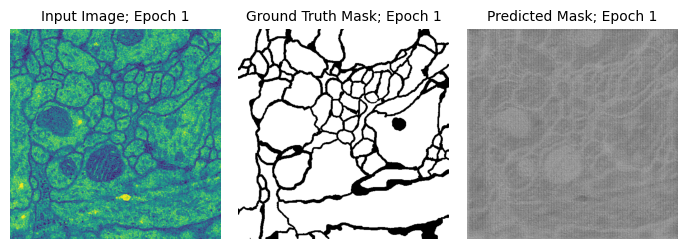

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5459 - dice_coef: 0.6424 - iou: 0.4795 - loss: 0.6835 - precision: 0.7837 - recall: 0.5740   
Epoch 1: val_loss improved from inf to 0.48178, saving model to model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5606 - dice_coef: 0.6539 - iou: 0.4929 - loss: 0.6719 - precision: 0.7837 - recall: 0.6004 - val_accuracy: 0.7926 - val_dice_coef: 0.8377 - val_iou: 0.7208 - val_loss: 0.4818 - val_precision: 0.7926 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7731 - dice_coef: 0.8203 - iou: 0.6954 - loss: 0.4959 - precision: 0.7731 - recall: 1.0000
Epoch 2: val_loss improved from 0.48178 to 0.44658, saving model to model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.7751 - dice_coef: 0.8203 - iou: 0.6954 - loss: 0.4905 - precision: 0.7751 - recall: 1.0000 - val_accuracy: 0.7926 - val_dice_coef: 0.8092 - val_iou: 0.6796 - val_loss: 0.4466 - val_preci

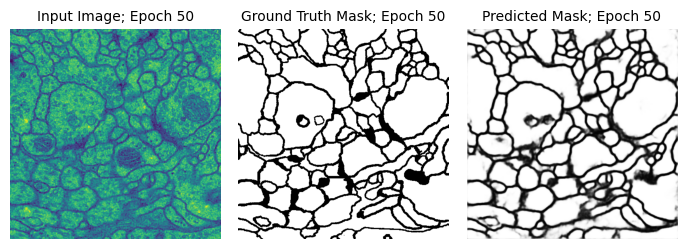


Epoch 50: val_loss did not improve from 0.19932
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.9295 - dice_coef: 0.9359 - iou: 0.8796 - loss: 0.1641 - precision: 0.9602 - recall: 0.9488 - val_accuracy: 0.9072 - val_dice_coef: 0.9247 - val_iou: 0.8600 - val_loss: 0.2191 - val_precision: 0.9607 - val_recall: 0.9206 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step - accuracy: 0.9094 - dice_coef: 0.9173 - iou: 0.8473 - loss: 0.2092 - precision: 0.9427 - recall: 0.9387


In [56]:
# Train the model
# Hyperparameters
num_epochs = 50
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    callbacks=callbacks,
    validation_data=valid_dataset,
    shuffle=False,
    verbose=1,
)

# Evaluate on test set
results = model.evaluate(test_dataset, return_dict=True, verbose=1)
# print(f"Test Dice Coefficient: {results['dice_coef']:.3f}")
# print(f"Test IoU: {results['iou']:.3f}")
# print(f"Test Recall: {results['recall']:.3f}")
# print(f"Test Precision: {results['precision']:.3f}")
# print(f"Test Loss: {results['loss']:.3f}")

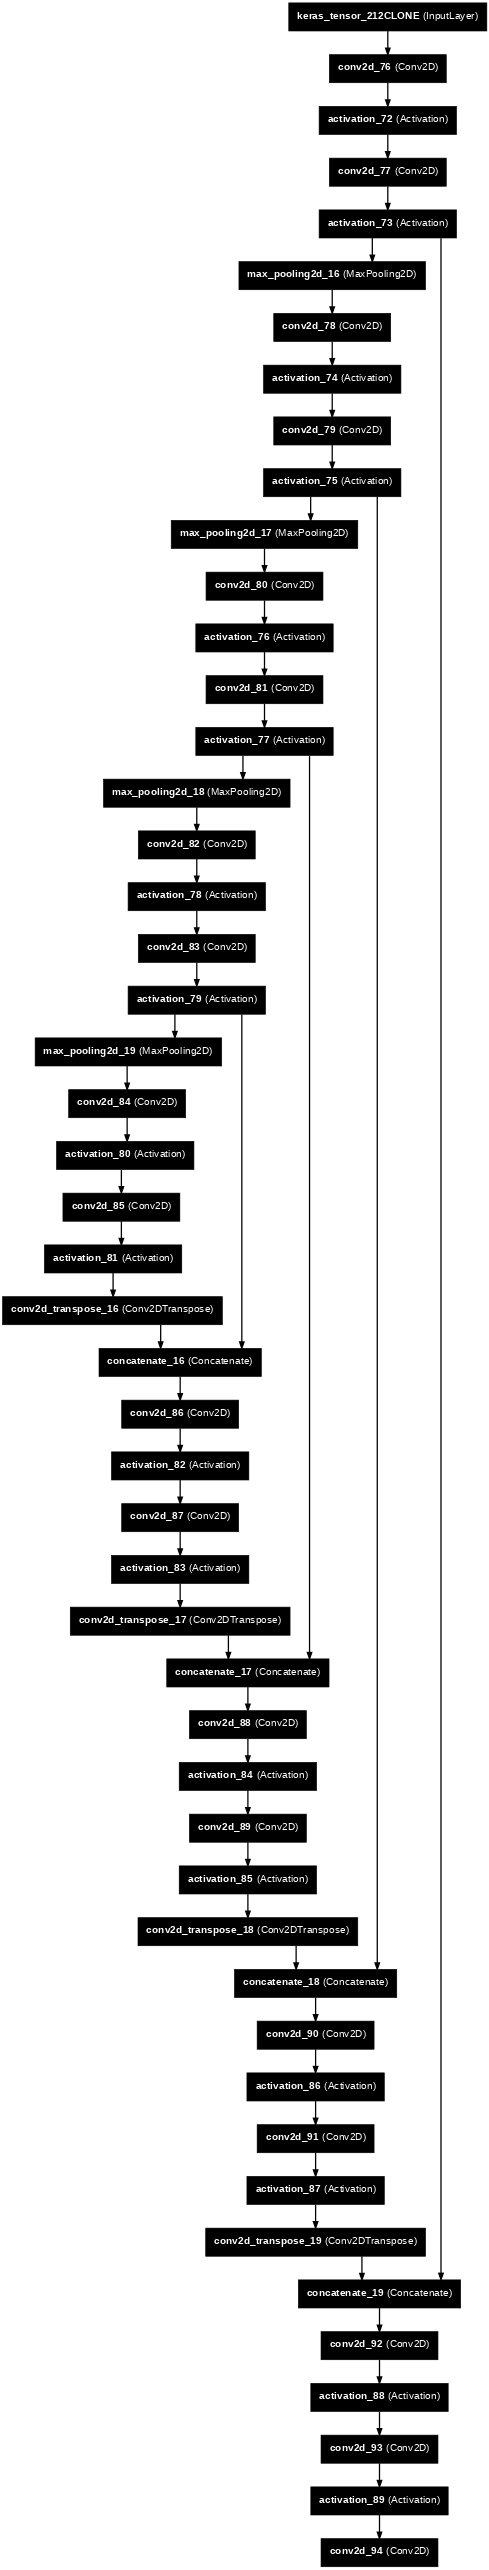

In [64]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=46,
    layer_range=None
)

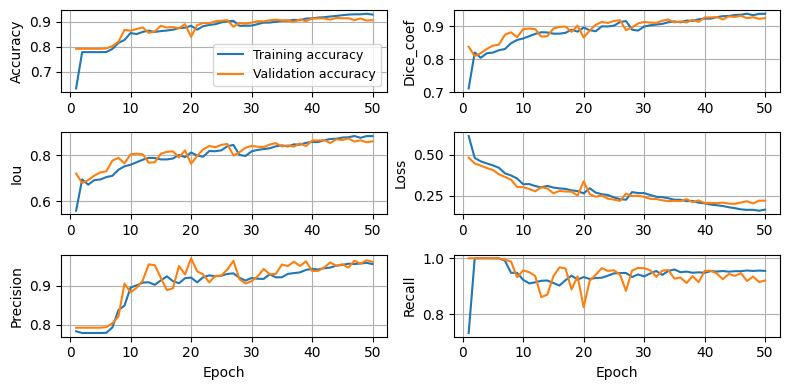

In [58]:
def plot_training_history(history, figsize=(6, 2.5)):
    """
    Plot training and validation metrics/loss over epochs based on available metrics in history.

    Overfitting:
     It happens when a model learns training data too well, including noise and specific patterns, leading to poor
     performance on unseen data. It often occurs when training metrics improve significantly while validation
     metrics plateau or worsen, showing the model memorizes rather than generalizes.
    - Signs of Overfitting:
      - Training metrics improve, but validation metrics plateau or decline.
      - A large gap between training and validation performance.
      - Strong performance on training data but poor results on test data.
    - Causes:
      - Complex Model: Too many parameters (e.g., deep U-Net) with a small dataset.
      - Small Dataset: Limited data leads to memorization instead of generalization.
      - Lack of Regularization: Missing techniques like dropout, weight decay, or data augmentation.

    Underfitting:
      It happens when a model fails to learn the training data, leading to poor performance on both training
      and validation/test sets. This can occur if the model is too simple or insufficiently trained to capture the
      data’s complexity.
    - Signs of Underfitting:
        - Low training and validation metrics that don’t improve significantly.
        - Training metrics improve slowly or plateau at suboptimal values.
        - Poor performance on the training set itself.
    - Causes:
        - Simple Model: Insufficient capacity (e.g., too few layers or filters).
        - Insufficient Training: Too few epochs or a high learning rate.
        - Small/Imbalanced Dataset: Lack of diversity limits generalizable learning.

    Precision:
    - It measures the proportion of predicted positive instances (foreground pixels in your case) that are actually correct.
    - High precision means the model is good at avoiding false positives—when it predicts a pixel as foreground, it’s usually correct.
    - Low precision indicates the model is predicting too many false positives (e.g., predicting background pixels as foreground).
    - True Positives (TP): Pixels correctly predicted as foreground (1).
    - False Positives (FP): Pixels incorrectly predicted as foreground (predicted 1, but actually 0).

    Recall (also called sensitivity):
    - It measures the proportion of actual positive instances (foreground pixels) that the model correctly identifies.
    - High recall means the model is good at detecting most of the foreground pixels, minimizing false negatives.
    - Low recall indicates the model is missing many foreground pixels (e.g., predicting them as background).
    - False Negatives (FN): Pixels that are actually foreground (1) but predicted as background (0).

    Args:
    - history: History object from model.fit()
    """
    # Get metrics with both training and validation versions
    metrics_to_plot = [m for m in history.history if not m.startswith('val_') and f'val_{m}' in history.history]

    # If no metrics found, raise an error
    if not metrics_to_plot: raise ValueError("No valid metrics found in history to plot.")

    # Define epochs range
    epochs = range(1, len(history.history['loss']) + 1)

    # Create subplots dynamically based on number of metrics
    n_metrics = len(metrics_to_plot)
    n_rows = (n_metrics + 1) // 2  # Ceiling division to determine rows
    n_cols = min(n_metrics, 2)     # Max 2 columns

    plt.figure(figsize=figsize)  # Adjust height based on number of rows

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(n_rows, n_cols, i)
        plt.plot(epochs, history.history[metric], label=f'Training {metric}')
        plt.plot(epochs, history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.ylabel(metric.capitalize(), fontsize=10)
        if i == 1: plt.legend(fontsize=9)
        if i == n_metrics - 1 or i == n_metrics: plt.xlabel('Epoch', fontsize=10)
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot the history
plot_training_history(history, figsize=(8, 4))

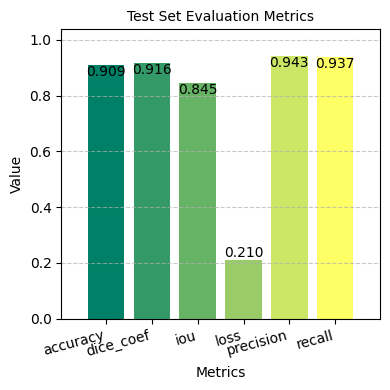

In [60]:
def plot_evaluation_results(results, figsize=(6, 2.5)):
    """
    Plot test set evaluation results as a bar chart based on available metrics in results.

    Args:
    - results: Dictionary from model.evaluate(return_dict=True)
    """
    # Extract all metrics from the results dictionary
    metrics_to_plot = list(results.keys())

    # If no metrics found, raise an error
    if not metrics_to_plot: raise ValueError("No metrics found in results to plot.")

    # Create bar plot with dynamic width and assigned colors
    plt.figure(figsize=figsize)

    # Get corresponding values
    values = [results[metric] for metric in metrics_to_plot]

    # Define a color map and assign colors to each bar
    colors = plt.cm.summer(np.linspace(0, 1, len(metrics_to_plot)))
    bars = plt.bar(metrics_to_plot, values, color=colors)

    # Add value labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}',
                 ha='center', va='bottom' if yval < 0.5 else 'top', color='black', rotation=0)

    plt.margins(x=0.1)
    plt.ylabel('Value', fontsize=10)
    plt.xticks(rotation=15, ha='right')
    plt.ylim(0, max(1.0, max(values) * 1.1))  # Adjust y-axis for visibility
    plt.xlabel('Metrics', fontsize=10, labelpad=5)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title('Test Set Evaluation Metrics', fontsize=10)
    plt.tight_layout()
    plt.show()

# Plot the results
plot_evaluation_results(results, figsize=(4, 4))

<font color=#5b0d8f size="4.5" face="Arial"><b>8️⃣ Test the model</b></font>

In [61]:
def evaluate_segmentation_predictions(test_dataset, predictions, num_sample=3):
    """
    Evaluate model predictions by calculating IoU and Dice coefficient for a batch of test images.

    Args:
    - test_dataset: Dataset containing test images and masks.
    - predictions: Model predictions (binary masks).

    Returns:
    - None: Prints IoU and Dice scores for each sample in the batch.

    IoU:
    - Computes Intersection over Union (IoU/Jaccard index) between masks. IoU measures the overlap between two samples
    with values ranging from 0 (no overlap) to 1 (perfect overlap). Defined as:
    IoU = |X ∩ Y| / |X ∪ Y|
    - Args:
        - y_true: Ground truth masks (tensor)
        - y_pred: Predicted masks (tensor)
    - Returns:
      - Tensor: Scalar IoU value

    Dice coefficient:
    - Computes the Dice coefficient (F1 score) between ground truth and predicted masks. The Dice coefficient measures
    the overlap between two samples, with values ranging from 0 (no overlap) to 1 (perfect overlap). Defined as:
    Dice = (2 * |X ∩ Y|) / (|X| + |Y|)
    - Args:
       - y_true: Ground truth masks (tensor)
       - y_pred: Predicted probability masks (tensor)
    - Returns:
       - Tensor: Scalar Dice coefficient value
    """
    # Convert predictions to binary (threshold at 0.5 for binary segmentation)
    predictions = (predictions > 0.5).astype(np.uint8)

    # Extract a small batch of data from test_dataset for visualization
    for batch in test_dataset.take(1):
        test_images, test_masks = batch
        break

    # Convert to numpy arrays for easier manipulation
    test_images = test_images.numpy()
    test_masks = test_masks.numpy()

    def iou(y_true, y_pred):
        # Ensure tensors are float32 for consistent computation
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Compute intersection
        intersection = tf.reduce_sum(y_true * y_pred)
        # Compute total area covered by both masks
        total = tf.reduce_sum(y_true + y_pred)
        # Compute union (total area minus intersection)
        union = total - intersection
        # Calculate IoU with smoothing factor
        return (intersection + 1e-4) / (union + 1e-4)

    def dice_coef(y_true, y_pred):
        # Ensure tensors are float32 for consistent computation
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Compute intersection (element-wise multiplication followed by sum)
        intersection = tf.reduce_sum(y_true * y_pred)
        # Compute union (sum of individual masks)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
        # Calculate Dice coefficient with smoothing factor
        return (2. * intersection + 1e-4) / (union + 1e-4)

    # Calculate IoU and Dice for each sample in the batch
    for i in range(num_sample):
        iou_score = iou(test_masks[i], predictions[i])
        acc = accuracy_score(test_masks[i].flatten(), predictions[i].flatten())
        dice_score = dice_coef(test_masks[i], predictions[i])
        rec = recall_score(test_masks[i].flatten(), predictions[i].flatten(), labels=[0, 1], average="binary")
        pre = precision_score(test_masks[i].flatten(), predictions[i].flatten(), labels=[0, 1], average="binary")

        print(f"Sample {i+1} Accuracy: {acc:.3f}; IoU: {iou_score:.3f}; Dice coef: {dice_score:.3f}; Recall: {rec:.3f}; Precision: {pre:.3f}")

In [62]:
predictions = model.predict(test_dataset, verbose=0)
evaluate_segmentation_predictions(test_dataset=test_dataset, predictions=predictions, num_sample=3)

Sample 1 Accuracy: 0.912; IoU: 0.890; Dice coef: 0.942; Recall: 0.939; Precision: 0.945
Sample 2 Accuracy: 0.912; IoU: 0.889; Dice coef: 0.941; Recall: 0.953; Precision: 0.930
Sample 3 Accuracy: 0.926; IoU: 0.911; Dice coef: 0.953; Recall: 0.956; Precision: 0.950


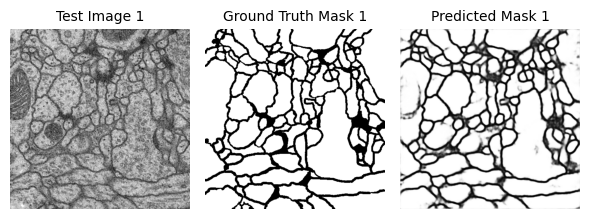

In [63]:
def display_predictions(test_images, test_masks, predictions, indx=0):
    plt.figure(figsize=(6, 4))

    # Original Image
    plt.subplot(131)
    plt.imshow(test_images[indx], cmap='gray')
    plt.title(f"Test Image {indx + 1}", fontsize=10)
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(132)
    plt.imshow(test_masks[indx], cmap='gray')
    plt.title(f"Ground Truth Mask {indx + 1}", fontsize=10)
    plt.axis('off')

    # Predicted Mask
    plt.subplot(133)
    plt.imshow(predictions[indx], cmap='gray')
    plt.title(f"Predicted Mask {indx + 1}", fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Extract a small batch of data from test_dataset for visualization
for batch in test_dataset.take(1):
    test_images, test_masks = batch
    break

# Convert to numpy arrays for easier manipulation
test_images = test_images.numpy()
test_masks = test_masks.numpy()

display_predictions(test_images, test_masks, predictions, indx=0)

<font color=#ff4578 size="4.5" face="Arial"><b>9️⃣ Load previously trained Model</b></font>

In [ ]:
model = load_model('model.keras')